# Fake and Real News Detection

The challenge is to develop a model to classify fake news and real news separately successfully. 

The flow of the document will be in the following manner:

- Data Exploration and Visualisation
- Data preprocessing/cleaning
- Implementation
- Model Evaluation
- Conclusion

## Data Exploration and Visualisation

### Fake and Real News Dataset

For this project we will use Fake and Real News Dataset available on Kaggle by Clément Bisaillon. The dataset contains 2 csv files containing fake and real news in separate files. The Fake.csv contains 17903 entries
and True.csv contains 20826 entries. We will merge both datasets randomly and create
a target value parameter as 0 and 1 for the fake and real news respectively in a separate
column.
Data fields
- title: The title of the article
- text: The text of the article
- subject: The subject of the article
- date: The date at which the article was posted

The full dataset can be downloaded from [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [1]:
# import libraries
import pandas as pd
import numpy as np
import os

In [2]:
# input your data path below
fake_df = pd.read_csv('/home/ashutosh/Desktop/capstone/data/Fake.csv')
real_df = pd.read_csv('/home/ashutosh/Desktop/capstone/data/True.csv')

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Data preprocessing/cleaning
We will merge the datasets and add target variable as Category to the data. We will then shuffle the data. Finally we will merge the text columns and delete unwanted columns from the data. We will use NLTK library to refine the text.

In [5]:
# Introducing category column in dataframes
real_df.insert(0,'category',1)
fake_df.insert(0,'category',0)

In [6]:
# Merging datasets into one df
df = pd.concat([real_df,fake_df])

# Shuffling Dataframe
df = df.sample(frac=1)

In [7]:
# checking NAN values
df.isna().sum()

category    0
title       0
text        0
subject     0
date        0
dtype: int64

In [8]:
# Analysis of news Subject
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [9]:
graph = df.subject.value_counts().plot(kind = 'bar')
graph.set_xlabel("News Subject")
graph.set_ylabel("Count")

In [10]:
# Merging attributes into 1
df['text'] = df['text'] + " " + df['title'] + " " + df['subject']
del df['title']
del df['subject']
del df['date']

We will now clean the text using nltk library by removing stopwords and stemming the data.

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download("stopwords", quiet=True)
import string

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
stemmer = PorterStemmer()

def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:  ## Remove stopwords
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)       

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
df.text = df.text.progress_apply(stem_text) #Applying stem_text function to whole dataframe

In [13]:
articles = df['text'].tolist()
labels = df['category'].tolist()

## Implementation
### Training and Testing Data Split
Before starting the training and the evaluation of the models, we split the dataset into test and training sets. The default split size is 25% which is done below.

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(articles, labels) #splitting data

In [15]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

Using TensorFlow backend.


In [16]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### NLP Techniques
Tokenization: is the process of tokenizing or splitting a string, text into a list of tokens. One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph.

Padding: When processing sequence data, it is very common for individual samples to have different lengths. Hence, we pad the sequences to make an array with each row being the vectorized values of each sentence.

In [17]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x_train)
padded_train = pad_sequences(sequences,5000,truncating='post')

In [18]:
sequences_test = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(sequences_test,5000,truncating='post')

In [19]:
padded_test.shape

(11225, 5000)

In [20]:
y_test.shape

(11225,)

## Benchmark Model
### Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


classifier = RandomForestClassifier(n_estimators = 50)
classifier.fit(padded_train, y_train)
y_pred = classifier.predict(padded_test).round()

### Benchmark Model Evaluation Metrics

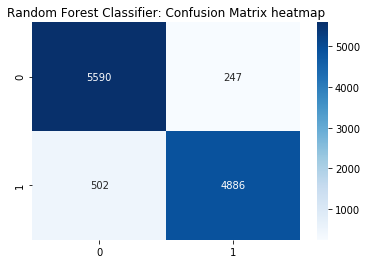

Accuracy: 0.9332739420935412


In [22]:
result = confusion_matrix(y_test, y_pred)
plt.figure()
plt.title("Random Forest Classifier: Confusion Matrix heatmap")
sns.heatmap(result, cmap= "Blues",annot = True, fmt='')
plt.show()
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)

### Create our Model
We will develop keras Sequential model with 4 layers for classification

The classification process followed the steps:

- Load the data 
- Clean the title removing not desired words
- Filter the outliers from the dataset
- Perform NLP on the data
- Divide the dataset in training and test
- Train the model and calculate the accuracy

In [26]:
model= tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = 5000),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])


In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 16)          160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               8000100   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 8,160,201
Trainable params: 8,160,201
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(padded_train, y_train, epochs = 3, validation_data=(padded_test, y_test))

Train on 33673 samples, validate on 11225 samples
Epoch 1/3
33673/33673 [==============================] - 73s 2ms/sample - loss: 0.0662 - acc: 0.9743 - val_loss: 7.1564e-04 - val_acc: 1.0000
Epoch 2/3
33673/33673 [==============================] - 71s 2ms/sample - loss: 4.9439e-04 - acc: 0.9999 - val_loss: 1.6197e-04 - val_acc: 1.0000
Epoch 3/3
33673/33673 [==============================] - 68s 2ms/sample - loss: 5.7903e-05 - acc: 1.0000 - val_loss: 7.8789e-05 - val_acc: 1.0000


## Model Evaluation
Use the predictor to generate predicted, class labels for the test data. Compare those to the true labels, test_y, and calculate the accuracy as a value between 0 and 1.0 that indicates the fraction of test data that your model classified correctly. We will use sklearn.metrics for this calculation.

In [29]:
print("Accuracy:",history.history['acc'][-1])
print("Validation Accuracy:",history.history['val_acc'][-1])

Accuracy: 1.0
Validation Accuracy: 1.0


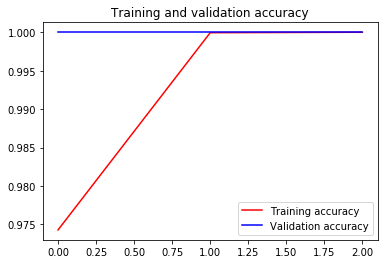

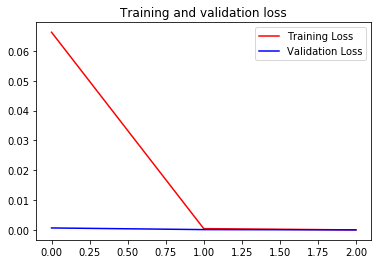

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
y_pred = model.predict(padded_test).round().astype(int)
cv_report = classification_report(y_test, y_pred, target_names = ['Fake','True'])
print(cv_report)

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      5837
        True       1.00      1.00      1.00      5388

   micro avg       1.00      1.00      1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



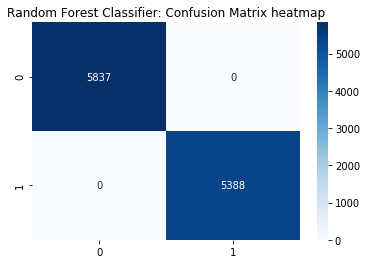

In [39]:
c_mat = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(c_mat, cmap= "Blues",annot = True, fmt='')
plt.title("Random Forest Classifier: Confusion Matrix heatmap")

The above heatmap shows 0 FP and 0 FN that indicates our model is precise and accurate

### Conclusion
- During the models' implementation a lot of steps were tested and some of them needed to be modified to reach better performance. For choosing a better parameter, we interacted over the options and decided on the one that optimized the accuracy.
- We can say that our model can predict fake news and real news quite accurately.
- The benchmark model gave the accuracy of 93%, we easily beat the accuracy by 7%.